<a href="https://colab.research.google.com/github/CrzPhil/IN3063-Coursework/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IN3063 - Coursework

## Libraries

In [ ]:
import math
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

## Sigmoid & ReLU

- By Aymen
- Reference:
    - https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
    - https://www.sharpsightlabs.com/blog/numpy-relu/
    - Lab 6

In [ ]:
# Forward pass for Sigmoid
def forward_sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Backward pass for Sigmoid
def backward_sigmoid(x):
    return forward_sigmoid(x) * (1 - forward_sigmoid(x))

In [ ]:
# Forward pass for ReLU
def forward_relu(x):
    return np.maximum(0, x)

# Backward pass for ReLU
def backward_relu(x):
    return np.where(x > 0, 1, 0)

## Softmax

- By Aymen
- Using the Numpy version
- Reference:
    - https://towardsdatascience.com/softmax-function-simplified-714068bf8156
    - https://en.wikipedia.org/wiki/Softmax_function
    - https://www.sharpsightlabs.com/blog/numpy-softmax/

In [ ]:
# Forward pass for Softmax
def forward_softmax(x):
    exponential = np.exp(x - np.max(x))
    return exponential / exponential.sum() # calculates softmax probability

# Backward pass for Softmax
def backward_softmax(x):
    return np.reshape(forward_softmax(x) * (1 - forward_softmax(x)), (1, -1)) # computes gradient of softmax

# Testing:
x = np.array([100.0, 2000.0, 300.0]) # large numbers
print("Forward pass result:", forward_softmax(x))
print("Backward pass result:", backward_softmax(x))
print ("\n")

x = np.array([1.0, 2.0, 3.0]) # small numbers
print("Forward pass result:", forward_softmax(x))
print("Backward pass result:", backward_softmax(x))

Forward pass result: [0. 1. 0.]
Backward pass result: [[0. 0. 0.]]


Forward pass result: [0.09003057 0.24472847 0.66524096]
Backward pass result: [[0.08192507 0.18483645 0.22269543]]


## Dropout

- By Adam
- References
  - Lecture 7
  - https://stackoverflow.com/questions/70836518/typeerror-bad-operand-type-for-unary-list-python
  - https://stackoverflow.com/questions/25854380/enforce-arguments-to-a-specific-list-of-values

In [ ]:
'''
Valid value structure constants.
They're defined here so they aren't recreated every time the function is ran.
'''
ACTIVATION_FUNCTIONS = {
    "sigmoid": [forward_sigmoid, backward_sigmoid],
    "relu": [forward_relu, backward_relu],
    "softmax": [forward_softmax, backward_softmax]
}

VALID_DIRECTIONS = ["forward", "backward"]

'''
Dropout function
    x = input vector
    probability is a float between 0.0 and 1.0
    activation_function is a string that corresponds to one of the key values above
        determines which activation function to use
    direction is a string that corresponds to one of the array values above
        determines whether to use a forward or backward pass activation function
    inverted is a boolean
        determines whether or not use inverted dropout
    train is a boolean
        determines whether to train or test
'''
def dropout(x, probability, activation_function, direction, inverted, train):
    if activation_function not in ACTIVATION_FUNCTIONS.keys():
        raise ValueError(f"Activation function must be one of {ACTIVATION_FUNCTIONS.keys()}")

    if direction not in VALID_DIRECTIONS:
        raise ValueError(f"Direction must be one of {VALID_DIRECTIONS}")

    value_index = 0 if direction == "forward" else 1

    H1 = ACTIVATION_FUNCTIONS[activation_function][value_index](x)
    mask = (np.random.rand(*H1.shape) < probability)

    if inverted:
        return H1 * (mask / probability) if train else H1
    else:
        return H1 * mask if train else H1 * probability

# Testing the function
#     Starting by defining x
x = np.array([2.0, 4.0, 7.0, 8.0])

#     Training
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", False, True)
print(H1_dropped)

#     Testing
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", False, False)
print(H1_dropped)

#     Training, inverted
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", True, True)
print(H1_dropped)

#     Testing, inverted
H1_dropped = dropout(x, 0.5, "sigmoid", "forward", True, True)
print(H1_dropped)

[0.         0.98201379 0.         0.99966465]
[0.44039854 0.4910069  0.49954447 0.49983232]
[1.76159416 0.         1.9981779  0.        ]
[1.76159416 0.         1.9981779  1.9993293 ]


In [ ]:
class SGDOptimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, parameter, gradient):
        return parameter - self.learning_rate * gradient

class SGDMomentumOptimizer:
    def __init__(self, learning_rate, momentum):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = {}

    def update(self, parameter, gradient):
        param_id = (parameter.shape, parameter.dtype)

        # Initialize the velocity for this parameter if it hasn't been initialized yet
        if param_id not in self.velocities:
            self.velocities[param_id] = np.zeros_like(parameter)

        self.velocities[param_id] = self.momentum * self.velocities[param_id] + self.learning_rate * gradient
        return parameter - self.velocities[param_id]

## Neural Network
- By Philip  
References:
  - Lecture 6
  - Lecture 7
  - https://towardsdatascience.com/step-by-step-guide-to-building-your-own-neural-network-from-scratch-df64b1c5ab6e
  - https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd

In [ ]:
# Reading the MNIST dataset as per http://yann.lecun.com/exdb/mnist/
import os
import struct

def read_idx(filename):
    with open(filename, 'rb') as file:
        # Read two bytes (big endian and unsigned)
        zero, data_type, dims = struct.unpack('>HBB', file.read(4))
        # Four byte integer big endian
        shape = tuple(struct.unpack('>I', file.read(4))[0] for d in range(dims))
        return np.frombuffer(file.read(), dtype=np.uint8).reshape(shape)

def load_mnist(path):
    # Paths to the files
    train_images_path = os.path.join(path, 'train-images-idx3-ubyte')
    train_labels_path = os.path.join(path, 'train-labels-idx1-ubyte')
    test_images_path = os.path.join(path, 't10k-images-idx3-ubyte')
    test_labels_path = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Loading the datasets
    train_images = read_idx(train_images_path)
    train_labels = read_idx(train_labels_path)
    test_images = read_idx(test_images_path)
    test_labels = read_idx(test_labels_path)

    return train_images, train_labels, test_images, test_labels

In [ ]:
# labels are just an array of 6000 elements; we need them as arrays of 10 elements
# 10 elements because MNIST can be digits 0-9; we need all elements to be 0 except
# the correct element, which will be 1.
def one_hot_encode(labels):
    one_hot_labels = np.zeros((len(labels), 10))
    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels

In [ ]:
class NeuralNet:
    def __init__(
        self,
        activation_function,
        neurons: list,
        learning_rate,
        optimizer,
        dropout_prob=None,
    ):
        """
        Initialises a new instance of the NeuralNet class.

        Parameters:
        activation_function (func): The activation function to be used in the network layers.
                                    The function is used in all layers.
        batch_size (int): The size of the batches used in training. This affects how the data is split during training iterations.
        neurons (list of int): The number of neurons in each layer. This should be a list where each element represents
                                the number of neurons in the respective layer of the network (input not included, output included and should be 10 for MNIST)
        learning_rate (float): Number between 0-1 specifying the learning rate of the NN.
        optimizer (func): Which optimizer to use (momentum / no momentum).
        dropout_prob (float): Optional- if specified, use dropout with this probability between 0-1.
                                Otherwise, no dropout.
        """

        ACTIVATION_FUNCTIONS = {
            "sigmoid": [forward_sigmoid, backward_sigmoid],
            "relu": [forward_relu, backward_relu],
        }

        self.activation_function = ACTIVATION_FUNCTIONS[activation_function]
        self.neurons = neurons
        self.layers = len(self.neurons)
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.dropout_prob = dropout_prob
        # Will be initialised once features are known
        self.weights = []
        self.biases = []

    def init_weights_and_biases(self, input_features):
        # Initialise weights and biases based on the layers, neurons, and input features
        # Fully connected through weights
        for i in range(self.layers):
            if i == 0:
                # input layer matrix needs to have as many columns as neurons
                layer_weights = np.random.randn(self.neurons[i], input_features) * 0.01
            else:
                # weights matrix with a column for each node in the previous layer and a row for each node in the current layer
                layer_weights = (
                    np.random.randn(self.neurons[i], self.neurons[i - 1]) * 0.01
                )
            layer_bias = np.zeros((self.neurons[i], 1))
            self.weights.append(layer_weights)
            self.biases.append(layer_bias)

    def forward_pass(self, X, is_training=True):
        activations = [X]
        for i in range(self.layers):
            Z = np.dot(self.weights[i], activations[-1]) + self.biases[i]
            A = self.apply_activation(Z)
            # Only apply dropout if a probability is specified and when training
            if self.dropout_prob and is_training:
                A = self.dropout(A, inverted=False)
            activations.append(A)
        return activations

    def dropout(self, A, inverted=True):
        if self.dropout_prob == 0:
            return A

        mask = np.random.rand(*A.shape) < (1 - self.dropout_prob)

        if inverted:
            A *= mask / (1 - self.dropout_prob)
        else:
            A *= mask
        return A

    def apply_activation(self, Z):
        return self.activation_function[0](Z)

    def backward_pass(self, Y, activations):
        m = Y.shape[1]
        n = len(self.weights)
        gradients = {}

        # Output layer
        dA = activations[-1] - Y  # Derivative of loss wrt (with respect to) output

        for i in reversed(range(n)):
            dZ = dA * self.activation_function[1](
                activations[i + 1]
            )  # gradient of loss wrt pre-activation values
            dW = np.dot(dZ, activations[i].T) / m  # gradient of loss wrt weights
            db = np.sum(dZ, axis=1, keepdims=True) / m  # gradient of loss wrt biases
            if i > 0:
                dA = np.dot(self.weights[i].T, dZ)

            gradients["dW" + str(i + 1)] = dW
            gradients["db" + str(i + 1)] = db

        return gradients

    def update_weights_and_biases(self, gradients, learning_rate):
        for i in range(self.layers):
            self.weights[i] = self.optimizer.update(
                self.weights[i], gradients["dW" + str(i + 1)]
            )
            self.biases[i] = self.optimizer.update(
                self.biases[i], gradients["db" + str(i + 1)]
            )

    def calculate_loss(self, Y_pred, Y_true):
        # Mean Squared Error
        return np.mean((Y_pred - Y_true) ** 2)

    def train_network(self, epochs, batch_size, X_train, Y_train):

        input_features = X_train.shape[1]

        # Initialise weights & biases
        self.init_weights_and_biases(input_features)
        loss_across_epochs = []

        for epoch in range(epochs):
            total_loss = 0
            # Iterate batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i : i + batch_size].T
                Y_batch = Y_train[i : i + batch_size].T

                # Forward pass over the batch
                activations = self.forward_pass(X_batch, is_training=True)

                # Backward pass over the batch (get gradients)
                gradients = self.backward_pass(Y_batch, activations)

                # Update weights & biases
                self.update_weights_and_biases(gradients, self.learning_rate)

                Y_pred = activations[-1]
                total_loss += self.calculate_loss(Y_pred, Y_batch)

            average_loss = total_loss / (X_train.shape[0] / batch_size)
            loss_across_epochs.append(average_loss)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

        return loss_across_epochs

    def evaluate_model(self, X_test, Y_test):
        # Forward pass
        activations = self.forward_pass(
            X_test.T, is_training=False
        )  # Transpose X_test for correct shape
        Y_pred = activations[-1]

        # Convert predictions to labels
        predictions = np.argmax(Y_pred, axis=0)
        labels = np.argmax(Y_test.T, axis=0)  # Transpose Y_test for correct shape

        # Calculate accuracy
        accuracy = np.mean(predictions == labels)

        # Calculate loss
        loss = self.calculate_loss(
            Y_pred, Y_test.T
        )  # Transpose Y_test for correct shape

        return accuracy, loss

# Training and evaluating the NeuralNet
> Works for sigmoid, relu, SDGOptimizer, SDGMomentumOptimizer, as well as any other optimizer, given it has an update() method that takes two parameters (parameter, gradient).

In [ ]:
train_images, train_labels, test_images, test_labels = load_mnist('./dataset')

# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

# Pick either of these optimizers for the Neural Net
learning_rate = 0.5
optimizer = SGDOptimizer(learning_rate=learning_rate)
#optimizer = SGDMomentumOptimizer(learning_rate=learning_rate, momentum=0.4)

# Create an instance of NeuralNet
nn = NeuralNet(activation_function='relu', neurons=[128, 10], learning_rate=learning_rate, optimizer=optimizer, dropout_prob=0.2)

# Train the network
loss_across = nn.train_network(epochs=20, batch_size=30, X_train=train_images, Y_train=train_labels)

Epoch 1/20, Loss: 0.035046323866425186
Epoch 2/20, Loss: 0.02822082893786462
Epoch 3/20, Loss: 0.027107865739857687
Epoch 4/20, Loss: 0.026479188807907512
Epoch 5/20, Loss: 0.025880567798050324
Epoch 6/20, Loss: 0.025794378257635673
Epoch 7/20, Loss: 0.02536978456978765
Epoch 8/20, Loss: 0.02518426902997608
Epoch 9/20, Loss: 0.025192409870081783
Epoch 10/20, Loss: 0.025144928448114126
Epoch 11/20, Loss: 0.02474722587372611
Epoch 12/20, Loss: 0.024650036422705867
Epoch 13/20, Loss: 0.0247251479751377
Epoch 14/20, Loss: 0.02422823421761457
Epoch 15/20, Loss: 0.024363348007911827
Epoch 16/20, Loss: 0.02409772181103068
Epoch 17/20, Loss: 0.024172597990375178
Epoch 18/20, Loss: 0.024326740390212178
Epoch 19/20, Loss: 0.023826295790448745
Epoch 20/20, Loss: 0.023938061230846477


In [ ]:
accuracy, loss = nn.evaluate_model(test_images, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")

Test Accuracy: 97.35%
Test Loss: 0.007334237550507167


# Plotting Results
References:
- https://matplotlib.org/stable/api/index.html
- Lab 02

In [ ]:
# Checkpoint function
import json

def save_results(results, filename="results.json"):
    with open(filename, 'w') as f:
        json.dump(results, f)

In [ ]:
train_images, train_labels, test_images, test_labels = load_mnist('./dataset')

# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

Here we will iterate through all combinations of the below parameters to then plot the various results and see what worked best and other interesting results. This took around 48 hours to compute with 32GB of RAM so I do not suggest running it.

In [ ]:
# All parameters configurations that we will try out to plot afterwards
layers = [[128, 10], [256, 10], [256, 128, 10]]
activation_funcs = ["sigmoid", "relu"]
optimizers = [SGDOptimizer, SGDMomentumOptimizer]
momentums = [.4, .6, .8]
learning_rates = [.2, .5, .7]
batch_sizes = [15, 30, 45, 80]
dropout_probs = [0, .1, .2, .4]
epochs = 50

In [ ]:
results = []

for layer in layers:
    for activation_f in activation_funcs:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                for dropout_prob in dropout_probs:
                    for optimizer_f in optimizers:
                        if optimizer_f == SGDOptimizer:
                            print(f"[+] {activation_f} - LR: {learning_rate} - BS: {batch_size} - DP: {dropout_prob} - OP: SGD")
                            optimizer = SGDOptimizer(learning_rate=learning_rate)
                            nn = NeuralNet(activation_function=activation_f,
                                          neurons=layer,
                                          learning_rate=learning_rate,
                                          optimizer=optimizer,
                                          dropout_prob=dropout_prob)
                            loss_across = nn.train_network(epochs=epochs,
                                                           batch_size=batch_size,
                                                          X_train=train_images,
                                                          Y_train=train_labels)
                            accuracy, loss = nn.evaluate_model(test_images, test_labels)

                            results.append({
                                "activation": activation_f,
                                "optimizer": "SGDOptimizer",
                                "learning_rate": learning_rate,
                                "batch_size": batch_size,
                                "layer": layer,
                                "dropout_prob": dropout_prob,
                                "accuracy": accuracy,
                                "loss": loss,
                                "loss_across": loss_across,
                            })
                            save_results(results)
                        else:
                            for momentum in momentums:
                                print(f"[+] {activation_f} - LR: {learning_rate} - BS: {batch_size} - DP: {dropout_prob} - MO: {momentum}")
                                optimizer = SGDMomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
                                nn = NeuralNet(activation_function=activation_f,
                                              neurons=layer,
                                              learning_rate=learning_rate,
                                              optimizer=optimizer,
                                              dropout_prob=dropout_prob)

                                loss_across = nn.train_network(epochs=epochs,
                                                               batch_size=batch_size,
                                                              X_train=train_images,
                                                              Y_train=train_labels)

                                accuracy, loss = nn.evaluate_model(test_images, test_labels)

                                results.append({
                                    "activation": activation_f,
                                    "optimizer": "SGDMomentumOptimizer",
                                    "momentum": momentum,
                                    "learning_rate": learning_rate,
                                    "batch_size": batch_size,
                                    "layer": layer,
                                    "dropout_prob": dropout_prob,
                                    "accuracy": accuracy,
                                    "loss": loss,
                                    "loss_across": loss_across,
                                })
                                save_results(results)

[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - OP: SGD


/tmp/ipykernel_28317/3392490630.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 15 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.2 - BS: 30 - DP: 0.

[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 45 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 80 - DP: 0.

[+] relu - LR: 0.7 - BS: 30 - DP: 0 - MO: 0.8
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.7 - BS: 30 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.7 - BS: 30 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.7 - BS: 30 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - OP: SGD
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - MO: 0.4
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - MO: 0.6
[+] relu - LR: 0.7 - BS: 45 - DP: 0 - MO: 0.8
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.7 - BS: 45 - DP: 0.1 - MO: 0.8
[+

[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 80 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.7 - BS: 15 - DP: 0.

[+] relu - LR: 0.5 - BS: 45 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 80 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 80 - DP: 0.1 - OP: SGD
[+] relu

[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 15 - DP: 0.4 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - OP: SGD
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.4
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.6
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.8
[+] sigmoid - LR: 0.5 - BS: 30 - DP: 0.

[+] relu - LR: 0.2 - BS: 45 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.2 - BS: 45 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.2 - BS: 80 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.5 - BS: 15 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 15 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 15 - DP: 0 - MO: 0.6
[+] re

/tmp/ipykernel_28317/2957073901.py:68: RuntimeWarning: invalid value encountered in multiply
  A *= mask


[+] relu - LR: 0.5 - BS: 30 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0.1 - MO: 0.8
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0.2 - MO: 0.8
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - OP: SGD
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - MO: 0.4
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - MO: 0.6
[+] relu - LR: 0.5 - BS: 30 - DP: 0.4 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - OP: SGD
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.4
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.6
[+] relu - LR: 0.5 - BS: 45 - DP: 0 - MO: 0.8
[+] relu - LR: 0.5 - BS: 45 - DP: 0.1 - OP: SGD
[+] relu

In [ ]:
results

[{'activation': 'sigmoid',
  'optimizer': 'SGDOptimizer',
  'learning_rate': 0.2,
  'batch_size': 15,
  'layer': [128, 10],
  'dropout_prob': 0,
  'accuracy': 0.9554,
  'loss': 0.008381873986850105,
  'loss_across': [0.0383301926098661,
   0.01772498484220288,
   0.016075874388572112,
   0.015326400926562494,
   0.014784656358611611,
   0.01430992892749696,
   0.01386182546398007,
   0.013424102502349418,
   0.012997096053258632,
   0.012584928389078565,
   0.012191030743510385,
   0.011820606624439785,
   0.011478128091340628,
   0.01116548322144054,
   0.010880715927134667,
   0.01061903070138493,
   0.010374605794275302,
   0.010142936952086545,
   0.009922008404774071,
   0.009711714132539895,
   0.009512778719534503,
   0.009325758761108615,
   0.009150432016854951,
   0.008986035028468984,
   0.008831866523990392,
   0.008687480483911323,
   0.008552543233386762,
   0.008426703164632308,
   0.008309590956567687,
   0.008200866651202092,
   0.00810020975221029,
   0.00800725828741

In [ ]:
len(results)

1152

# Plotting Loss across epochs for each architecture

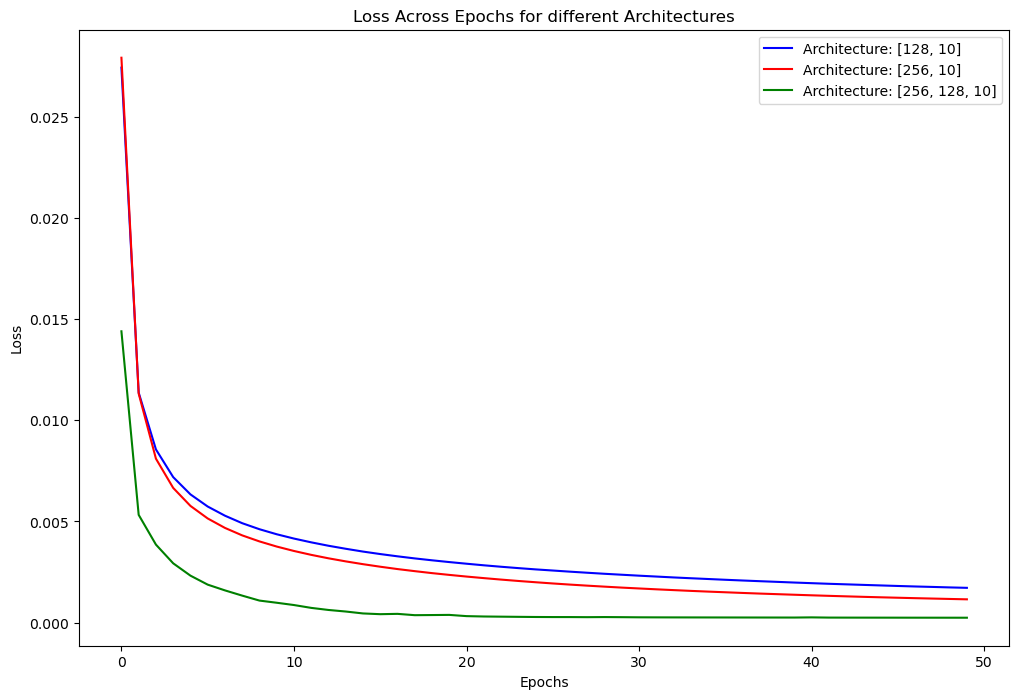

In [ ]:
plt.figure(figsize=(12, 8))
colours = ['blue', 'red', 'green']

for i, layer in enumerate(layers):
    # Find the entry with the highest accuracy for this architecture
    best_entry = max((item for item in results if item['layer'] == layer), key=lambda x: x['accuracy'])

    plt.plot(best_entry['loss_across'], label=f'Architecture: {layer}', color=colours[i])

    plt.title(f'Loss Across Epochs for different Architectures')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting impact of learning rate for activation/optimizer combinations

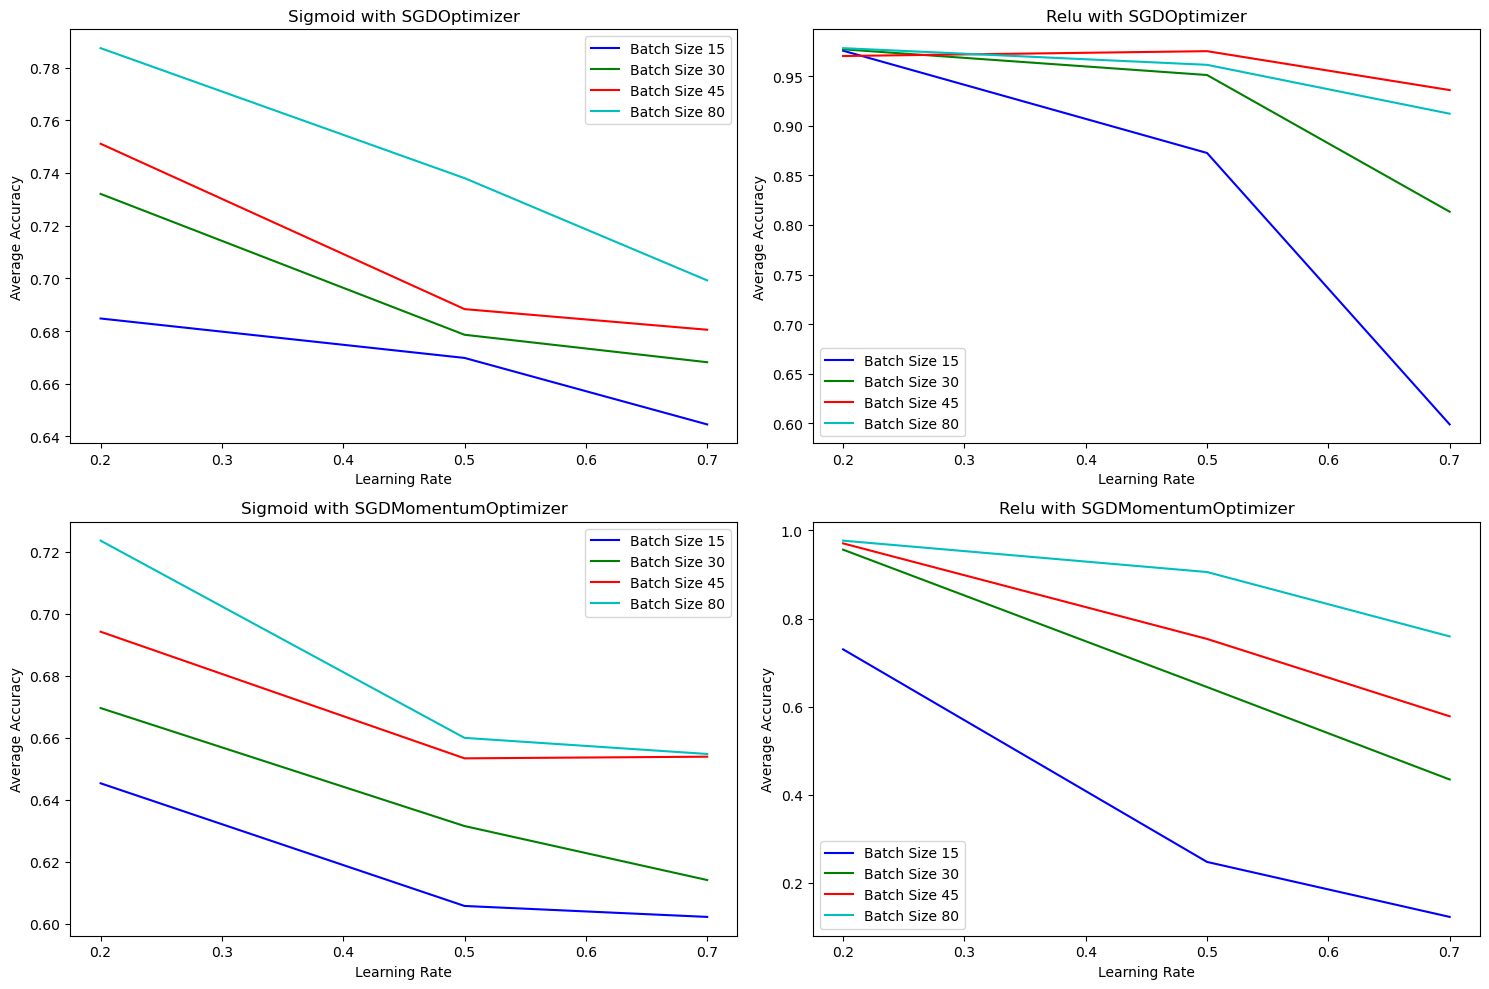

In [ ]:
colors = ['b', 'g', 'r', 'c', 'm', 'y']
architecture = [256, 128, 10]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Titles for each subplot
titles = [
    "Sigmoid with SGDOptimizer",
    "Relu with SGDOptimizer",
    "Sigmoid with SGDMomentumOptimizer",
    "Relu with SGDMomentumOptimizer"
]

# Arrange the data and plots
for i, (activation, optimizer) in enumerate([
    ("sigmoid", "SGDOptimizer"),
    ("relu", "SGDOptimizer"),
    ("sigmoid", "SGDMomentumOptimizer"),
    ("relu", "SGDMomentumOptimizer")
]):
    ax = axes[i//2, i%2]  # Determine the correct subplot

    # Filter data for the specific activation function and optimizer
    filtered_data = [entry for entry in results if entry['activation'] == activation and entry['optimizer'] == optimizer]

    # Plot each batch size with different color
    for batch_size, color in zip(batch_sizes, colors):
        # Calculate average accuracy for each learning rate
        accuracies = []
        for lr in learning_rates:
            # Filter data for specific learning rate and batch size
            lr_data = [entry['accuracy'] for entry in filtered_data if entry['learning_rate'] == lr and entry['batch_size'] == batch_size]
            avg_accuracy = sum(lr_data) / len(lr_data) if lr_data else None  # Calculate average if data is available
            accuracies.append(avg_accuracy)

        # Plotting the line for each batch size
        ax.plot(learning_rates, accuracies, color=color, label=f'Batch Size {batch_size}')

    ax.set_title(titles[i])
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Average Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()

# Plotting dropout impact for different architectures, separated by activation function

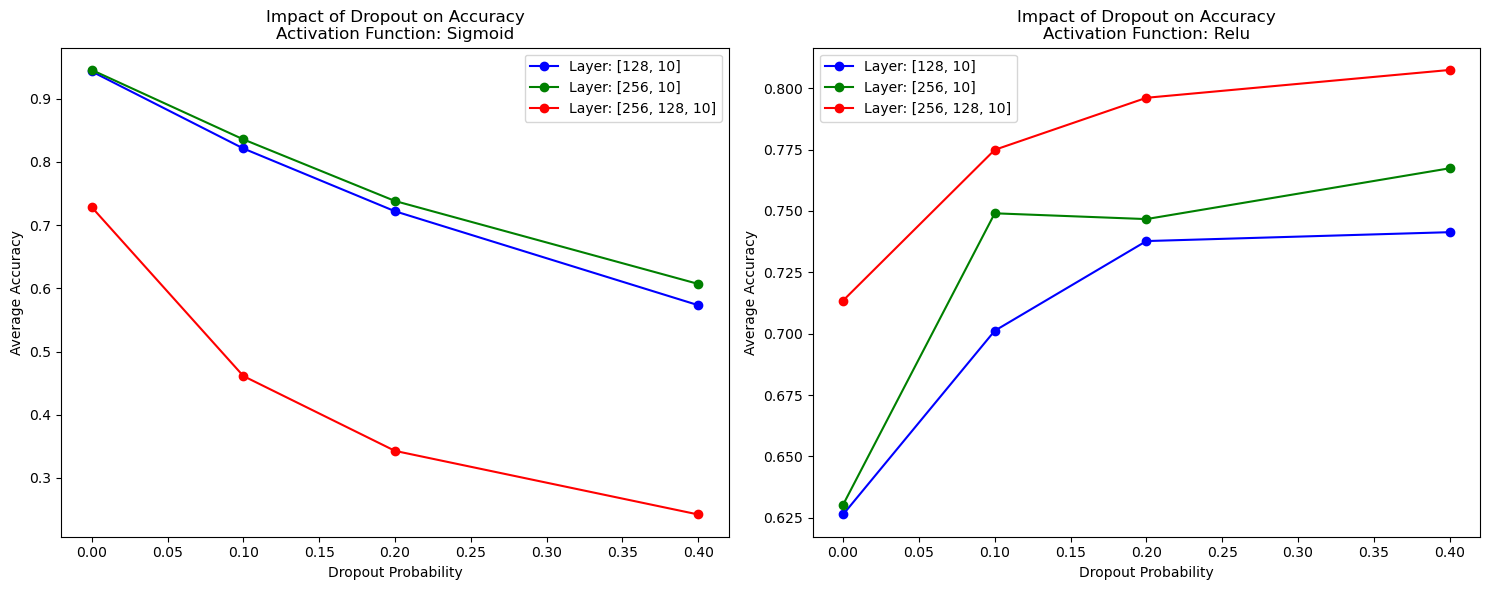

In [ ]:
colors = ['b', 'g', 'r']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns for sigmoid and relu

# Iterate through each activation function and plot
for idx, activation_f in enumerate(activation_funcs):
    ax = axes[idx]

    # For each layer architecture
    for layer, color in zip(layers, colors):
        accuracies = []

        # Collect accuracies for each dropout probability
        for dropout in dropout_probs:
            # Filter results for the specific combination
            layer_data = [entry for entry in results if entry['layer'] == layer and entry['activation'] == activation_f and entry['dropout_prob'] == dropout]
            avg_accuracy = sum([d['accuracy'] for d in layer_data]) / len(layer_data) if layer_data else None
            accuracies.append(avg_accuracy)

        # Plotting for each architecture
        ax.plot(dropout_probs, accuracies, color=color, marker='o', label=f'Layer: {layer}')

    ax.set_title(f'Impact of Dropout on Accuracy\nActivation Function: {activation_f.capitalize()}')
    ax.set_xlabel('Dropout Probability')
    ax.set_ylabel('Average Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
results

[{'activation': 'sigmoid',
  'optimizer': 'SGDMomentum',
  'momentum': 0.4,
  'learning_rate': 0.5,
  'batch_size': 10,
  'layer': [128, 10],
  'accuracy': 0.9259,
  'loss': 0.013002418626049367,
  'loss_across': [0.02095349556187284,
   0.014808658138667819,
   0.013793419397060408,
   0.01313527390485475,
   0.012607553407570488,
   0.012234835766318676,
   0.012012839940690374,
   0.011792184607668751,
   0.01144505098349533,
   0.011188405844738106,
   0.011211526960266503,
   0.011336840126469733,
   0.01137383461415806,
   0.011219148513135886,
   0.01123878448612132,
   0.01128463095222883,
   0.011392264134457873,
   0.011446416696135386,
   0.011412328499412216,
   0.011392087409168103]},
 {'activation': 'sigmoid',
  'optimizer': 'SGDMomentum',
  'momentum': 0.6,
  'learning_rate': 0.5,
  'batch_size': 10,
  'layer': [128, 10],
  'accuracy': 0.9165,
  'loss': 0.014215866690676452,
  'loss_across': [0.019825804671906935,
   0.014440719598230806,
   0.013588393085350262,
   0.01

# Taking a look at our 'best' result and its configuration

In [ ]:
accuracies = [i['accuracy'] for i in results]

In [ ]:
max(accuracies)

0.9858

In [ ]:
# Our best result across the board
best_result = [re for re in results if re['accuracy'] == 0.9858][0]

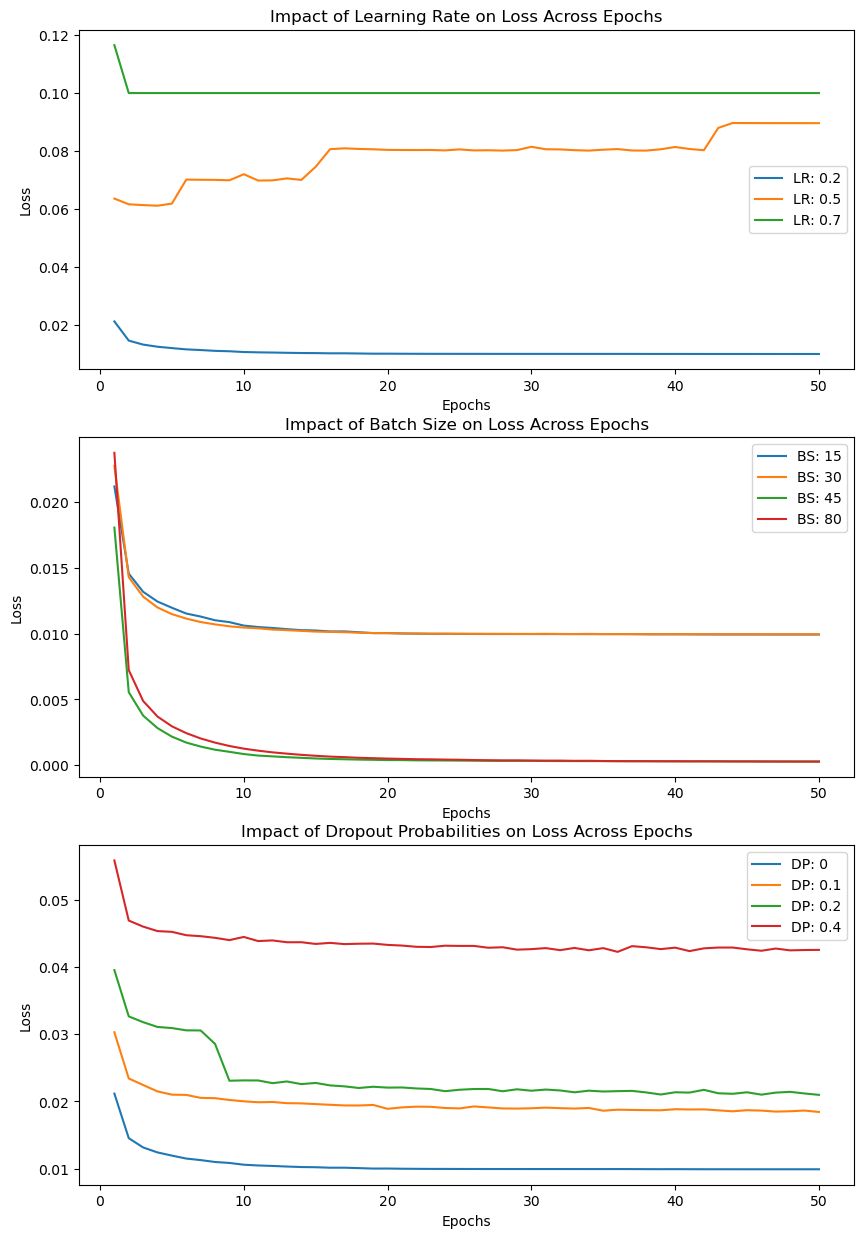

In [ ]:
# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for varying learning rates
for lr in learning_rates:
    specific_results = [r for r in results if r['activation'] == best_result['activation']
                        and r['optimizer'] == best_result['optimizer']
                        and r['momentum'] == best_result['momentum']
                        and r['layer'] == best_result['layer']
                        and r['learning_rate'] == lr]
    if specific_results:
        avg_loss_across = specific_results[0]['loss_across']
        axes[0].plot(range(1, len(avg_loss_across)+1), avg_loss_across, label=f'LR: {lr}')

axes[0].set_title('Impact of Learning Rate on Loss Across Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot for varying batch sizes
for bs in batch_sizes:
    specific_results = [r for r in results if r['activation'] == best_result['activation']
                        and r['optimizer'] == best_result['optimizer']
                        and r['momentum'] == best_result['momentum']
                        and r['layer'] == best_result['layer']
                        and r['batch_size'] == bs]
    if specific_results:
        avg_loss_across = specific_results[0]['loss_across']
        axes[1].plot(range(1, len(avg_loss_across)+1), avg_loss_across, label=f'BS: {bs}')

axes[1].set_title('Impact of Batch Size on Loss Across Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Plot for varying dropout probabilities
for dp in dropout_probs:
    specific_results = [r for r in results if r['activation'] == best_result['activation']
                        and r['optimizer'] == best_result['optimizer']
                        and r['momentum'] == best_result['momentum']
                        and r['layer'] == best_result['layer']
                        and r['dropout_prob'] == dp]
    if specific_results:
        avg_loss_across = specific_results[0]['loss_across']
        axes[2].plot(range(1, len(avg_loss_across)+1), avg_loss_across, label=f'DP: {dp}')

axes[2].set_title('Impact of Dropout Probabilities on Loss Across Epochs')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')
axes[2].legend()

# Demonstration of our 'strongest' configuration with seed

In [ ]:
np.random.seed(31415)

In [ ]:
best_result

{'activation': 'relu',
 'optimizer': 'SGDMomentumOptimizer',
 'momentum': 0.6,
 'learning_rate': 0.5,
 'batch_size': 45,
 'layer': [256, 128, 10],
 'dropout_prob': 0,
 'accuracy': 0.9858,
 'loss': 0.002780826218288223,
 'loss_across': [0.014405494777687102,
  0.0053263236577529936,
  0.0038552118788943894,
  0.0029301502456128303,
  0.0023201844806740495,
  0.0018755845695625282,
  0.0015907767144778759,
  0.0013323551699570286,
  0.0010867660570402342,
  0.0009796903900065725,
  0.0008662094041064235,
  0.0007255670113295868,
  0.0006226301547266212,
  0.0005457292834077984,
  0.00045067427836683693,
  0.00041404332060183496,
  0.00043004016654067624,
  0.00036474923926815915,
  0.00037126894530133776,
  0.00037873391021233673,
  0.0003181119111929249,
  0.0002998006439637034,
  0.000290996920738343,
  0.0002827005227520857,
  0.0002753303354642801,
  0.00027152851558835987,
  0.00027095678303912376,
  0.00026637286913308616,
  0.0002715131557211232,
  0.0002662285788145819,
  0.00025

In [ ]:
train_images, train_labels, test_images, test_labels = load_mnist('./dataset')

# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
train_labels = one_hot_encode(train_labels)
test_labels = one_hot_encode(test_labels)

learning_rate = 0.5
optimizer = SGDMomentumOptimizer(learning_rate=learning_rate, momentum=0.6)

# Create an instance of NeuralNet
nn = NeuralNet(activation_function='relu', neurons=[256, 128, 10], learning_rate=learning_rate, optimizer=optimizer, dropout_prob=0)

# Train the network
loss_across = nn.train_network(epochs=50, batch_size=45, X_train=train_images, Y_train=train_labels)

accuracy, loss = nn.evaluate_model(test_images, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss}")

Epoch 1/50, Loss: 0.01501019457740331
Epoch 2/50, Loss: 0.005389193631725706
Epoch 3/50, Loss: 0.0038060114899221716
Epoch 4/50, Loss: 0.002981839985524178
Epoch 5/50, Loss: 0.0023220988595752923
Epoch 6/50, Loss: 0.0019225727967120856
Epoch 7/50, Loss: 0.0015735827778337232
Epoch 8/50, Loss: 0.0013259888796953612
Epoch 9/50, Loss: 0.0011224119007342832
Epoch 10/50, Loss: 0.0009691007804848152
Epoch 11/50, Loss: 0.0008599212745595865
Epoch 12/50, Loss: 0.0007514570885710419
Epoch 13/50, Loss: 0.0005964872356532308
Epoch 14/50, Loss: 0.0005152613324259686
Epoch 15/50, Loss: 0.0004621613771741157
Epoch 16/50, Loss: 0.00042314379869063014
Epoch 17/50, Loss: 0.0003837230973101019
Epoch 18/50, Loss: 0.0003496045180198098
Epoch 19/50, Loss: 0.0003287316261907615
Epoch 20/50, Loss: 0.00033015602955024687
Epoch 21/50, Loss: 0.00031599733919556854
Epoch 22/50, Loss: 0.0002863393418864634
Epoch 23/50, Loss: 0.00027721681737556117
Epoch 24/50, Loss: 0.0002691795341928754
Epoch 25/50, Loss: 0.0002

# Task 2

## Base model
- By Aymen
- Reference:
  - https://datagen.tech/guides/image-classification/python/
  - Lab 9

In [2]:
# BEFORE YOU RUN THIS CODE:
# Make sure you download the "chest-xray" folder and upload it to your Google Drive
# Takes around 1-2 hours to upload the folder
# Then, run this code and sign in to your Google Drive account
# You should now see a folder called "/content/drive/MyDrive/chest_xray"

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Libaries taken from Lab9.1
import torch
import torchvision
import torchvision.transforms as transforms
#pytorch utility imports
import torch
from torch.utils.data import DataLoader, TensorDataset
#neural net imports
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
#import external libraries
import pandas as pd,numpy as np,matplotlib.pyplot as plt, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [25]:
## Creating a dataset
# Displays total files and classes
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/chest_xray",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5866 files belonging to 3 classes.
Using 4693 files for training.
Using 1173 files for validation.


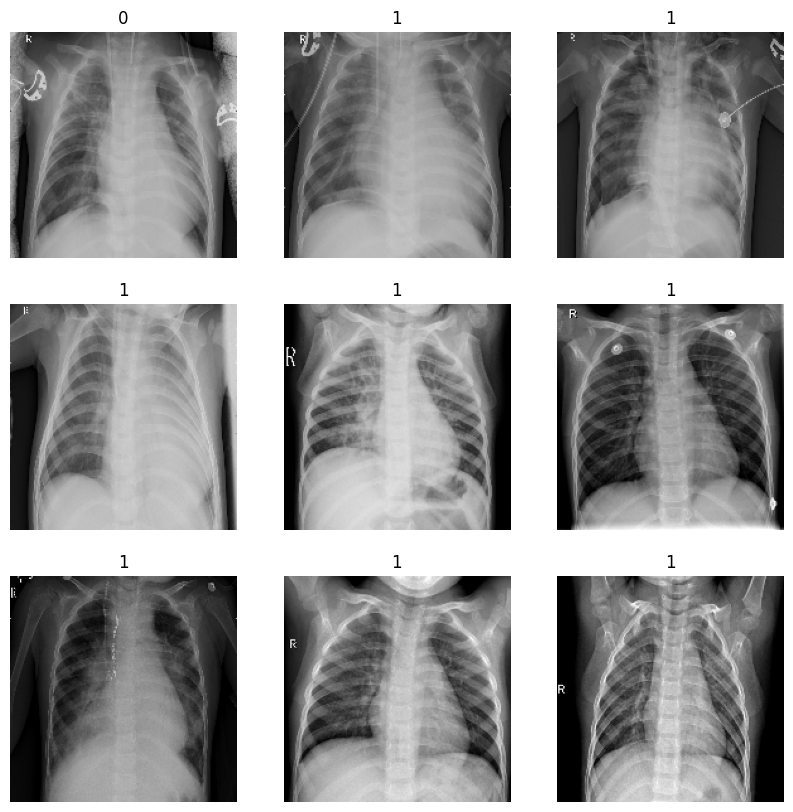

In [26]:
## Visualise data
# Prints the first 9 images in training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()